<a href="https://colab.research.google.com/github/HarshithReddy04/Price-Recommendation-for-Online-Sellers/blob/main/Price_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
df = pd.read_csv("/content/train.tsv", sep = '\t')

In [3]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
train.shape, test.shape

((298758, 8), (75113, 8))

Text(0.5, 1.0, 'Price Distribution')

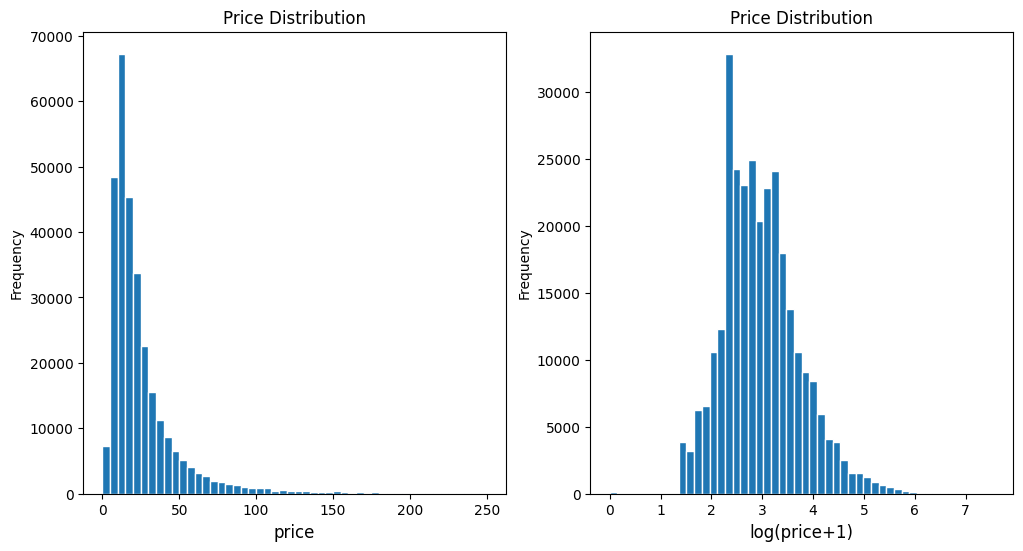

In [4]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)
plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

In [5]:
train['shipping'].value_counts() / len(train)

0    0.553341
1    0.446659
Name: shipping, dtype: float64

In [6]:
shipping_fee_by_buyer = train.loc[df['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[df['shipping'] == 1, 'price']
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 22.66 if seller pays shipping
The average price is 30.0 if buyer pays shipping


In [7]:
print('There are', train['category_name'].nunique(), 'unique values in category name column')

There are 1107 unique values in category name column


<Axes: xlabel='item_condition_id', ylabel='price'>

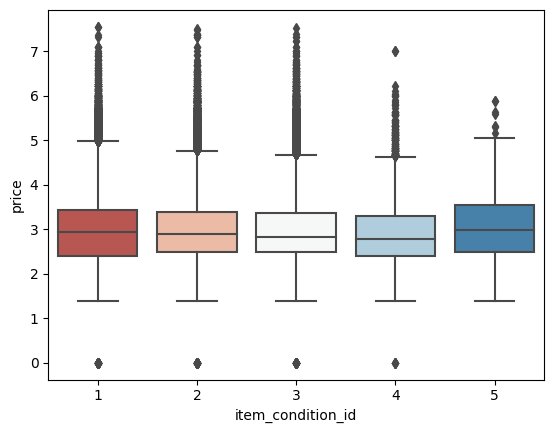

In [8]:
sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu',5))

LIGHTGBM

LightGBM, short for light gradient-boosting machine, is a free and open-source distributed gradient-boosting framework for machine learning

In [9]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

There are some missing values in the columns that need to be fixed:

In [10]:
print('There are %d items that do not have a category name.' %train['category_name'].isnull().sum())

There are 1306 items that do not have a category name.


In [11]:
print('There are %d items that do not have a brand name.' %train['brand_name'].isnull().sum())

There are 127254 items that do not have a brand name.


In [12]:
print('There are %d items that do not have a description.' %train['item_description'].isnull().sum())

There are 0 items that do not have a description.


HELPER function for the LightGBM

In [13]:
def handle_missing_inplace(dataset):
    dataset['category_name'].fillna(value='missing', inplace=True)
    dataset['brand_name'].fillna(value='missing', inplace=True)
    dataset['item_description'].replace('No description yet,''missing', inplace=True)
    dataset['item_description'].fillna(value='missing', inplace=True)
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [14]:
df = pd.read_csv("/content/train.tsv", sep = '\t')
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
test_new = test.drop('price', axis=1)
y_test = np.log1p(test["price"])
train = train[train.price != 0].reset_index(drop=True)

Merging train and test Data

In [15]:
nrow_train = train.shape[0]
y = np.log1p(train["price"])
merge: pd.DataFrame = pd.concat([train, test_new])

In [16]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

In [17]:
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

In [18]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

In [19]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])


In [20]:
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)

In [21]:
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

In [22]:
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [23]:
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

In [24]:
train_X = lgb.Dataset(X, label=y)

In [25]:
params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

Use ‘regression’ as application as we are dealing with a regression problem.
Use ‘RMSE’ as metric because this is a regression problem.
“num_leaves”=100 as our data is relative big.
Use “max_depth” to avoid overfitting.
Use “verbosity” to control the level of LightGBM’s verbosity (<0: Fatal).
“learning_rate” determines the impact of each tree on the final outcome.

Training a model requires a parameter list and data set so the training will take a while.



In [26]:
gbm = lgb.train(params, train_set=train_X, num_boost_round=3200)

In [27]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

Final Evaluation

In [28]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.4896240016367201


The Root Mean Square Error value of the prediction is: 0.4896240016367201